In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

/home/sinha/miniconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# use gpu for torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device = }")

device = device(type='cuda')


In [3]:
# load data 
df = pd.read_csv('data/cities_sample.csv')
df.head()

,statement,label,embeddings
0,Al Fqih Ben Calah is a name of a country.,0,"[-1.1005859375, 0.466064453125, 0.86474609375,..."
1,Londrina is a city in Indonesia.,0,"[-1.4140625, -0.00347900390625, 1.37890625, -1..."
2,Klang is a city in Japan.,0,"[-1.3759765625, 0.34814453125, 0.8681640625, -..."
3,Luhansk is a name of a country.,0,"[-0.75146484375, 0.7978515625, 1.0927734375, -..."
4,Nagasaki is a city in Turkey.,0,"[-1.046875, -0.38671875, 1.259765625, -0.72314..."


In [4]:
# load gpt-2 model
model = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model, device = device)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model)
model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [13]:
model.transformer.h[-4].ln_2.normalized_shape[0]

768

In [30]:
# Extend the model for binary classification
class BinaryHeadModel(nn.Module):
    def __init__(self, layer_to_use = -4):
        super().__init__()
        self.model = model
        self.freeze()
        self.layer_to_use = layer_to_use
        self.input_dim = self.model.transformer.h[self.layer_to_use].ln_2.normalized_shape[0]
        # self.input_dim = self.model.lm_head.out_features
        self.linear_1 = nn.Linear(self.input_dim, 256)
        self.linear_2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()

    def forward(self, x):
        x = self.model(**x, output_hidden_states=True, return_dict=True)
        # x = self.softmax(x['logits'][0][-1])
        x = x.hidden_states[self.layer_to_use][:,-1,:] # batch_size, last_token, hidden_size
        # print(x.shape)
        x = nn.ReLU()(x)
        x = self.linear_1(x)
        x = nn.ReLU()(x)
        # print(x.shape)
        x = self.linear_2(x)
        # print(x.shape)
        x = self.sigmoid(x)
        # print(x.shape)
        return x

    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
    
    def loss_fn(self, y_pred, y_true):
        return self.loss(y_pred, y_true)
    
custom_model = BinaryHeadModel(layer_to_use = -1)
custom_model.to(device)

BinaryHeadModel(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (linear_1): Linear(in_features

In [31]:
# test model
test_input = df['statement'].iloc[0:5]
print(f'Statement: {test_input}')
test_input = tokenizer(list(test_input), padding=True, return_tensors="pt")
test_input = test_input.to(device)
print(test_input)
test_output = custom_model(test_input)
print(test_output)

Statement: 0    Al Fqih Ben Calah is a name of a country.
1             Londrina is a city in Indonesia.
2                    Klang is a city in Japan.
3              Luhansk is a name of a country.
4                Nagasaki is a city in Turkey.
Name: statement, dtype: object
{'input_ids': tensor([[ 2348,   376,    80,  4449,  3932,  2199,   993,   318,   257,  1438,
           286,   257,  1499,    13],
        [   43,   623, 22267,   318,   257,  1748,   287, 16256,    13, 50256,
         50256, 50256, 50256, 50256],
        [   42, 17204,   318,   257,  1748,   287,  2869,    13, 50256, 50256,
         50256, 50256, 50256, 50256],
        [   43,  7456, 34738,   318,   257,  1438,   286,   257,  1499,    13,
         50256, 50256, 50256, 50256],
        [   45,   363, 33846,   318,   257,  1748,   287,  7137,    13, 50256,
         50256, 50256, 50256, 50256]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [32]:
# get X and y variable
X = df['statement'].values
y = df['label'].values
# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (800,)
X_test shape:  (200,)
y_train shape:  (800,)
y_test shape:  (200,)


In [33]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        batch_X = self.X[index]
        batch_y = self.y[index]
        return batch_X, batch_y    

    def preprocess(self, X):
        return tokenizer(X, padding=True, return_tensors="pt")

    def collate(self, batch):
        X = [item[0] for item in batch]
        X = self.preprocess(X).to(device)
        y = torch.tensor([item[1] for item in batch], dtype = torch.float).to(device)
        return X, y

In [34]:
# create train and test dataset
train_dataset = dataset(X_train, y_train)
test_dataset = dataset(X_test, y_test)

print(f"{train_dataset[0] = }")
print(f"{test_dataset[0] = }")

train_dataset[0] = ('Russia is a name of a city.', 0)
test_dataset[0] = ('Palhoca is a name of a city.', 1)


In [35]:
# train the model
batch_size = 16
epochs = 20
optimizer = optim.AdamW(custom_model.parameters(), lr=1e-5, eps=1e-8)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate)
results = []
for epoch in range(epochs):
    for i, batch in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x = batch[0]
        y = batch[1]
        y_pred = custom_model(x)
        loss = custom_model.loss_fn(torch.squeeze(y_pred, dim = -1), y)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")
            with torch.no_grad():
                test_dataloder = DataLoader(test_dataset, 
                                          batch_size=len(test_dataset), 
                                          shuffle=False, 
                                          collate_fn=test_dataset.collate)
                x_test, y_test = next(iter(test_dataloder))
                y_pred = custom_model(x_test).detach().cpu().numpy()
                y_pred = np.where(y_pred > 0.5, 1, 0)
                print(f"Test Accuracy: {accuracy_score(y_test.detach().cpu().numpy(), y_pred)}")
                results.append((epoch, i, loss.item(), accuracy_score(y_test.detach().cpu().numpy(), y_pred)))

0it [00:00, ?it/s]

Epoch: 0, Batch: 0, Loss: 0.7171009182929993


4it [00:01,  4.47it/s]

Test Accuracy: 0.535


9it [00:01,  9.95it/s]

Epoch: 0, Batch: 10, Loss: 0.8135864734649658


13it [00:02,  6.41it/s]

Test Accuracy: 0.535


18it [00:02, 10.54it/s]

Epoch: 0, Batch: 20, Loss: 0.7245802879333496


24it [00:03,  7.97it/s]

Test Accuracy: 0.535


28it [00:03, 10.73it/s]

Epoch: 0, Batch: 30, Loss: 0.697248101234436


33it [00:04,  7.42it/s]

Test Accuracy: 0.535


40it [00:05, 12.10it/s]

Epoch: 0, Batch: 40, Loss: 0.7197868824005127


44it [00:06,  7.18it/s]

Test Accuracy: 0.535


50it [00:06,  7.73it/s]
0it [00:00, ?it/s]

Epoch: 1, Batch: 0, Loss: 0.7081185579299927


3it [00:00,  4.20it/s]

Test Accuracy: 0.535


10it [00:01, 12.51it/s]

Epoch: 1, Batch: 10, Loss: 0.7066491842269897


15it [00:02,  7.53it/s]

Test Accuracy: 0.51


20it [00:02, 11.28it/s]

Epoch: 1, Batch: 20, Loss: 0.6991332769393921


24it [00:03,  7.09it/s]

Test Accuracy: 0.53


28it [00:03, 10.35it/s]

Epoch: 1, Batch: 30, Loss: 0.6928329467773438


34it [00:04,  7.86it/s]

Test Accuracy: 0.535


39it [00:04, 11.55it/s]

Epoch: 1, Batch: 40, Loss: 0.6775058507919312


44it [00:05,  7.96it/s]

Test Accuracy: 0.485


50it [00:06,  8.15it/s]
0it [00:00, ?it/s]

Epoch: 2, Batch: 0, Loss: 0.6889145374298096


4it [00:00,  5.31it/s]

Test Accuracy: 0.465


9it [00:01, 10.91it/s]

Epoch: 2, Batch: 10, Loss: 0.6801791191101074


14it [00:02,  7.41it/s]

Test Accuracy: 0.48


20it [00:02, 12.16it/s]

Epoch: 2, Batch: 20, Loss: 0.6946408152580261


25it [00:03,  7.81it/s]

Test Accuracy: 0.5


30it [00:03, 11.35it/s]

Epoch: 2, Batch: 30, Loss: 0.697187602519989


34it [00:04,  7.06it/s]

Test Accuracy: 0.525


39it [00:04, 11.01it/s]

Epoch: 2, Batch: 40, Loss: 0.7017396092414856


43it [00:05,  7.02it/s]

Test Accuracy: 0.525


50it [00:06,  8.10it/s]
0it [00:00, ?it/s]

Epoch: 3, Batch: 0, Loss: 0.7043038010597229


3it [00:00,  4.14it/s]

Test Accuracy: 0.47


9it [00:01, 11.59it/s]

Epoch: 3, Batch: 10, Loss: 0.7087190747261047


14it [00:02,  7.45it/s]

Test Accuracy: 0.485


19it [00:02, 11.59it/s]

Epoch: 3, Batch: 20, Loss: 0.7116535902023315


23it [00:03,  7.09it/s]

Test Accuracy: 0.495


30it [00:03, 12.68it/s]

Epoch: 3, Batch: 30, Loss: 0.6968860626220703


32it [00:04,  5.86it/s]

Test Accuracy: 0.48


40it [00:04, 11.31it/s]

Epoch: 3, Batch: 40, Loss: 0.6960563659667969


42it [00:05,  5.74it/s]

Test Accuracy: 0.475


50it [00:06,  8.02it/s]
0it [00:00, ?it/s]

Epoch: 4, Batch: 0, Loss: 0.6887803077697754


3it [00:00,  4.11it/s]

Test Accuracy: 0.475


8it [00:01, 10.37it/s]

Epoch: 4, Batch: 10, Loss: 0.689152717590332


14it [00:02,  7.77it/s]

Test Accuracy: 0.505


18it [00:02, 10.79it/s]

Epoch: 4, Batch: 20, Loss: 0.6933004260063171


23it [00:03,  7.31it/s]

Test Accuracy: 0.495


29it [00:03, 11.65it/s]

Epoch: 4, Batch: 30, Loss: 0.6818202137947083


34it [00:04,  7.93it/s]

Test Accuracy: 0.52


39it [00:04, 11.65it/s]

Epoch: 4, Batch: 40, Loss: 0.6909381747245789


43it [00:05,  7.11it/s]

Test Accuracy: 0.48


50it [00:06,  8.14it/s]
0it [00:00, ?it/s]

Epoch: 5, Batch: 0, Loss: 0.6944363713264465


4it [00:00,  5.40it/s]

Test Accuracy: 0.52


9it [00:01, 10.98it/s]

Epoch: 5, Batch: 10, Loss: 0.6995317935943604


14it [00:02,  7.36it/s]

Test Accuracy: 0.51


19it [00:02, 11.03it/s]

Epoch: 5, Batch: 20, Loss: 0.6968094110488892


23it [00:03,  6.99it/s]

Test Accuracy: 0.495


30it [00:03, 11.97it/s]

Epoch: 5, Batch: 30, Loss: 0.6911346912384033


34it [00:04,  7.23it/s]

Test Accuracy: 0.49


38it [00:04, 10.51it/s]

Epoch: 5, Batch: 40, Loss: 0.6789689660072327


44it [00:05,  7.85it/s]

Test Accuracy: 0.535


50it [00:06,  8.13it/s]
0it [00:00, ?it/s]

Epoch: 6, Batch: 0, Loss: 0.6825053095817566


3it [00:00,  4.05it/s]

Test Accuracy: 0.53


10it [00:01, 12.60it/s]

Epoch: 6, Batch: 10, Loss: 0.6927274465560913


12it [00:02,  5.46it/s]

Test Accuracy: 0.54


18it [00:02,  9.97it/s]

Epoch: 6, Batch: 20, Loss: 0.6785925030708313


24it [00:03,  7.94it/s]

Test Accuracy: 0.525


30it [00:03, 11.94it/s]

Epoch: 6, Batch: 30, Loss: 0.6911446452140808


34it [00:04,  7.52it/s]

Test Accuracy: 0.505


39it [00:04, 11.10it/s]

Epoch: 6, Batch: 40, Loss: 0.708962619304657


43it [00:05,  7.03it/s]

Test Accuracy: 0.54


50it [00:06,  8.11it/s]
0it [00:00, ?it/s]

Epoch: 7, Batch: 0, Loss: 0.6865831017494202


3it [00:00,  4.17it/s]

Test Accuracy: 0.515


10it [00:01, 12.37it/s]

Epoch: 7, Batch: 10, Loss: 0.7001603245735168


14it [00:02,  6.72it/s]

Test Accuracy: 0.485


19it [00:02, 10.87it/s]

Epoch: 7, Batch: 20, Loss: 0.69439697265625


24it [00:03,  7.62it/s]

Test Accuracy: 0.475


29it [00:03, 11.45it/s]

Epoch: 7, Batch: 30, Loss: 0.6853732466697693


33it [00:04,  7.05it/s]

Test Accuracy: 0.475


39it [00:04, 11.57it/s]

Epoch: 7, Batch: 40, Loss: 0.707766592502594


43it [00:05,  7.27it/s]

Test Accuracy: 0.485


50it [00:06,  8.00it/s]
0it [00:00, ?it/s]

Epoch: 8, Batch: 0, Loss: 0.6984614133834839


3it [00:00,  4.21it/s]

Test Accuracy: 0.465


10it [00:01, 12.54it/s]

Epoch: 8, Batch: 10, Loss: 0.6839674711227417


14it [00:02,  6.97it/s]

Test Accuracy: 0.515


19it [00:02, 11.35it/s]

Epoch: 8, Batch: 20, Loss: 0.6874173879623413


24it [00:03,  7.67it/s]

Test Accuracy: 0.475


29it [00:03, 11.35it/s]

Epoch: 8, Batch: 30, Loss: 0.6795717477798462


34it [00:04,  7.77it/s]

Test Accuracy: 0.52


39it [00:04, 11.08it/s]

Epoch: 8, Batch: 40, Loss: 0.7143479585647583


44it [00:05,  7.50it/s]

Test Accuracy: 0.54


50it [00:06,  8.02it/s]
0it [00:00, ?it/s]

Epoch: 9, Batch: 0, Loss: 0.6743137836456299


3it [00:00,  4.14it/s]

Test Accuracy: 0.54


8it [00:01, 10.28it/s]

Epoch: 9, Batch: 10, Loss: 0.6952448487281799


14it [00:02,  7.67it/s]

Test Accuracy: 0.485


20it [00:02, 12.04it/s]

Epoch: 9, Batch: 20, Loss: 0.6994776725769043


24it [00:03,  7.27it/s]

Test Accuracy: 0.48


30it [00:03, 11.60it/s]

Epoch: 9, Batch: 30, Loss: 0.7030665278434753


35it [00:04,  7.92it/s]

Test Accuracy: 0.515


40it [00:04, 11.32it/s]

Epoch: 9, Batch: 40, Loss: 0.6861979961395264


44it [00:05,  7.26it/s]

Test Accuracy: 0.545


50it [00:06,  8.10it/s]
0it [00:00, ?it/s]

Epoch: 10, Batch: 0, Loss: 0.6989996433258057


4it [00:00,  5.29it/s]

Test Accuracy: 0.485


8it [00:01,  9.89it/s]

Epoch: 10, Batch: 10, Loss: 0.6987539529800415


13it [00:02,  6.81it/s]

Test Accuracy: 0.475


18it [00:02, 10.79it/s]

Epoch: 10, Batch: 20, Loss: 0.6978235244750977


24it [00:03,  7.74it/s]

Test Accuracy: 0.51


29it [00:03, 11.19it/s]

Epoch: 10, Batch: 30, Loss: 0.7057019472122192


34it [00:04,  7.80it/s]

Test Accuracy: 0.5


40it [00:04, 11.61it/s]

Epoch: 10, Batch: 40, Loss: 0.694031298160553


44it [00:05,  7.43it/s]

Test Accuracy: 0.475


50it [00:06,  8.05it/s]
0it [00:00, ?it/s]

Epoch: 11, Batch: 0, Loss: 0.6940299272537231


4it [00:00,  5.34it/s]

Test Accuracy: 0.515


9it [00:01, 11.21it/s]

Epoch: 11, Batch: 10, Loss: 0.6671515703201294


13it [00:02,  6.70it/s]

Test Accuracy: 0.54


20it [00:02, 12.01it/s]

Epoch: 11, Batch: 20, Loss: 0.6437536478042603


24it [00:03,  7.12it/s]

Test Accuracy: 0.54


29it [00:03, 10.88it/s]

Epoch: 11, Batch: 30, Loss: 0.6763507127761841


34it [00:04,  7.60it/s]

Test Accuracy: 0.535


39it [00:04, 11.00it/s]

Epoch: 11, Batch: 40, Loss: 0.6770696640014648


44it [00:05,  7.63it/s]

Test Accuracy: 0.5


50it [00:06,  8.04it/s]
0it [00:00, ?it/s]

Epoch: 12, Batch: 0, Loss: 0.6951894760131836


4it [00:00,  5.23it/s]

Test Accuracy: 0.53


10it [00:01, 11.73it/s]

Epoch: 12, Batch: 10, Loss: 0.6827112436294556


14it [00:02,  6.89it/s]

Test Accuracy: 0.475


19it [00:02, 11.03it/s]

Epoch: 12, Batch: 20, Loss: 0.692419171333313


24it [00:03,  7.69it/s]

Test Accuracy: 0.51


30it [00:03, 11.95it/s]

Epoch: 12, Batch: 30, Loss: 0.6877657175064087


34it [00:04,  7.31it/s]

Test Accuracy: 0.54


38it [00:04, 10.38it/s]

Epoch: 12, Batch: 40, Loss: 0.7060433626174927


43it [00:05,  7.19it/s]

Test Accuracy: 0.53


50it [00:06,  8.08it/s]
0it [00:00, ?it/s]

Epoch: 13, Batch: 0, Loss: 0.6852906942367554


4it [00:00,  5.28it/s]

Test Accuracy: 0.54


8it [00:01, 10.04it/s]

Epoch: 13, Batch: 10, Loss: 0.7028365731239319


13it [00:02,  6.76it/s]

Test Accuracy: 0.475


19it [00:02, 11.59it/s]

Epoch: 13, Batch: 20, Loss: 0.6798831224441528


24it [00:03,  7.55it/s]

Test Accuracy: 0.51


30it [00:03, 12.17it/s]

Epoch: 13, Batch: 30, Loss: 0.6778149008750916


34it [00:04,  7.05it/s]

Test Accuracy: 0.51


38it [00:04, 10.15it/s]

Epoch: 13, Batch: 40, Loss: 0.6949516534805298


44it [00:05,  7.69it/s]

Test Accuracy: 0.48


50it [00:06,  7.95it/s]
0it [00:00, ?it/s]

Epoch: 14, Batch: 0, Loss: 0.6782742738723755


3it [00:00,  4.16it/s]

Test Accuracy: 0.53


10it [00:01, 13.03it/s]

Epoch: 14, Batch: 10, Loss: 0.6795737743377686


14it [00:02,  6.99it/s]

Test Accuracy: 0.49


18it [00:02, 10.46it/s]

Epoch: 14, Batch: 20, Loss: 0.6925684213638306


23it [00:03,  7.19it/s]

Test Accuracy: 0.475


29it [00:03, 11.55it/s]

Epoch: 14, Batch: 30, Loss: 0.6830914616584778


33it [00:04,  7.18it/s]

Test Accuracy: 0.515


40it [00:04, 12.51it/s]

Epoch: 14, Batch: 40, Loss: 0.6907284259796143


45it [00:05,  7.87it/s]

Test Accuracy: 0.51


50it [00:06,  8.08it/s]
0it [00:00, ?it/s]

Epoch: 15, Batch: 0, Loss: 0.6684521436691284


3it [00:00,  4.13it/s]

Test Accuracy: 0.52


9it [00:01, 11.69it/s]

Epoch: 15, Batch: 10, Loss: 0.693210244178772


14it [00:02,  7.26it/s]

Test Accuracy: 0.54


19it [00:02, 11.20it/s]

Epoch: 15, Batch: 20, Loss: 0.7181981205940247


23it [00:03,  6.95it/s]

Test Accuracy: 0.54


29it [00:03, 11.62it/s]

Epoch: 15, Batch: 30, Loss: 0.67877197265625


34it [00:04,  7.63it/s]

Test Accuracy: 0.54


38it [00:04, 10.70it/s]

Epoch: 15, Batch: 40, Loss: 0.6764209270477295


44it [00:05,  7.99it/s]

Test Accuracy: 0.545


50it [00:06,  8.03it/s]
0it [00:00, ?it/s]

Epoch: 16, Batch: 0, Loss: 0.6830785274505615


4it [00:00,  5.34it/s]

Test Accuracy: 0.5


9it [00:01, 11.10it/s]

Epoch: 16, Batch: 10, Loss: 0.6885085105895996


13it [00:02,  6.61it/s]

Test Accuracy: 0.54


20it [00:02, 12.49it/s]

Epoch: 16, Batch: 20, Loss: 0.6707673072814941


24it [00:03,  6.96it/s]

Test Accuracy: 0.515


30it [00:03, 11.81it/s]

Epoch: 16, Batch: 30, Loss: 0.6896154284477234


35it [00:04,  7.62it/s]

Test Accuracy: 0.455


39it [00:05, 10.37it/s]

Epoch: 16, Batch: 40, Loss: 0.6659772396087646


44it [00:06,  7.36it/s]

Test Accuracy: 0.49


50it [00:06,  7.93it/s]
0it [00:00, ?it/s]

Epoch: 17, Batch: 0, Loss: 0.671998143196106


3it [00:00,  4.05it/s]

Test Accuracy: 0.505


10it [00:01, 12.61it/s]

Epoch: 17, Batch: 10, Loss: 0.6816616058349609


14it [00:02,  6.85it/s]

Test Accuracy: 0.53


20it [00:02, 11.62it/s]

Epoch: 17, Batch: 20, Loss: 0.6836808919906616


24it [00:03,  7.16it/s]

Test Accuracy: 0.515


28it [00:03, 10.27it/s]

Epoch: 17, Batch: 30, Loss: 0.6756338477134705


34it [00:04,  7.68it/s]

Test Accuracy: 0.48


39it [00:04, 11.05it/s]

Epoch: 17, Batch: 40, Loss: 0.6538466811180115


44it [00:05,  7.82it/s]

Test Accuracy: 0.505


50it [00:06,  8.03it/s]
0it [00:00, ?it/s]

Epoch: 18, Batch: 0, Loss: 0.6838937401771545


3it [00:00,  4.10it/s]

Test Accuracy: 0.47


9it [00:01, 10.97it/s]

Epoch: 18, Batch: 10, Loss: 0.671934962272644


13it [00:02,  6.70it/s]

Test Accuracy: 0.52


20it [00:02, 12.24it/s]

Epoch: 18, Batch: 20, Loss: 0.6674869060516357


25it [00:03,  7.86it/s]

Test Accuracy: 0.54


29it [00:03, 10.64it/s]

Epoch: 18, Batch: 30, Loss: 0.6470502018928528


34it [00:04,  7.28it/s]

Test Accuracy: 0.535


38it [00:04, 10.16it/s]

Epoch: 18, Batch: 40, Loss: 0.6602452397346497


43it [00:05,  6.97it/s]

Test Accuracy: 0.535


50it [00:06,  7.90it/s]
0it [00:00, ?it/s]

Epoch: 19, Batch: 0, Loss: 0.6889617443084717


3it [00:00,  4.18it/s]

Test Accuracy: 0.5


9it [00:01, 11.70it/s]

Epoch: 19, Batch: 10, Loss: 0.7119271159172058


14it [00:02,  7.30it/s]

Test Accuracy: 0.455


19it [00:02, 11.47it/s]

Epoch: 19, Batch: 20, Loss: 0.6779194474220276


23it [00:03,  7.03it/s]

Test Accuracy: 0.47


29it [00:03, 11.74it/s]

Epoch: 19, Batch: 30, Loss: 0.7027498483657837


34it [00:04,  7.59it/s]

Test Accuracy: 0.49


39it [00:04, 11.22it/s]

Epoch: 19, Batch: 40, Loss: 0.6800709962844849


43it [00:05,  7.07it/s]

Test Accuracy: 0.505


50it [00:06,  8.01it/s]


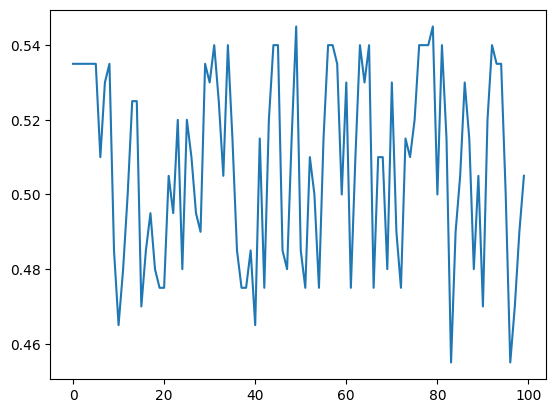

In [36]:
plt.plot([acc for _,_,_,acc in results ])